In [1]:
import json

import bz2
from tqdm import tqdm_notebook
from scipy import sparse
import re

In [2]:
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
responses = []
with bz2.BZ2File('banki_responses.json.bz2', 'r') as thefile:
    for row in tqdm_notebook(thefile):
        resp = json.loads(row)
        if not resp['rating_not_checked'] and (len(resp['text'].split()) > 0):
            responses.append(resp)

/Users/erik/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


#  Домашнее задание по NLP # 1 [100 баллов]
## Классификация по тональности 

В этом домашнем задании вам предстоит классифицировать по тональности отзывы на банки с сайта banki.ru.

Данные содержат непосредственно тексты отзывов, некоторую дополнительную информацию, а также оценку по шкале от 1 до 5. 

Тексты хранятся в json-ах в массиве responses.

Посмотрим на пример отзыва:

In [4]:
responses[99]

{'city': 'г. Саратов',
 'rating_not_checked': False,
 'title': 'Карта ко вкладу',
 'num_comments': 0,
 'bank_license': 'лицензия № 880',
 'author': 'ronnichka',
 'bank_name': 'Югра',
 'datetime': '2015-06-03 20:56:57',
 'text': 'Здравствуйте! Хотела написать, что мне месяц не выдают карту ко вкладу, ссылаясь на "нам же их из Самары везут" (на секундочку 5 часов езды от нашего города). Но! Прочитала, что людям 3,5 месяцев не выдают карту, и поняла, что у меня все хорошо, пока что. И подарок мне дали, и кулер в отделении есть. Так что я, конечно, готова ждать. Правда хотелось бы не очень долго.',
 'rating_grade': 3}

## Часть 1. Анализ текстов [40/100]

1. Посчитайте количество отзывов в разных городах и на разные банки
2. Постройте гистограмы длин слов в символах и в словах
3. Найдите 10 самых частых:
    * слов
    * слов без стоп-слов
    * лемм 
* существительных
4. Постройте кривые Ципфа и Хипса
5. Ответьте на следующие вопросы:
    * какое слово встречается чаще, "сотрудник" или "клиент"?
    * сколько раз встречается слова "мошенничество" и "доверие"?
6. В поле "rating_grade" записана оценка отзыва по шкале от 1 до 5. Используйте меру $tf-idf$, для того, чтобы найти ключевые слова и биграмы для положительных отзывов (с оценкой 5) и отрицательных отзывов (с оценкой 1)

In [5]:
df = pd.DataFrame(responses)

In [6]:
df.head()

,city,rating_not_checked,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade
0,г. Москва,False,Жалоба,0,лицензия № 2562,uhnov1,Бинбанк,2015-06-08 12:50:54,Добрый день! Я не являюсь клиентом банка и пор...,NaN
1,г. Новосибирск,False,Не могу пользоваться услугой Сбербанк он-лайн,0,лицензия № 1481,Foryou,Сбербанк России,2015-06-08 11:09:57,Доброго дня! Являюсь держателем зарплатной кар...,NaN
2,г. Москва,False,Двойное списание за один товар.,1,лицензия № 2562,Vladimir84,Бинбанк,2015-06-05 20:14:28,Здравствуйте! Дублирую свое заявление от 03.0...,NaN
3,г. Ставрополь,False,Меняют проценты комиссии не предупредив и не ...,2,лицензия № 1481,643609,Сбербанк России,2015-06-05 13:51:01,Добрый день!! Я открыл расчетный счет в СберБа...,NaN
4,г. Челябинск,False,Верните денежные средства за страховку,1,лицензия № 2766,anfisa-2003,ОТП Банк,2015-06-05 10:58:12,"04.03.2015 г. взяла кредит в вашем банке, заяв...",NaN


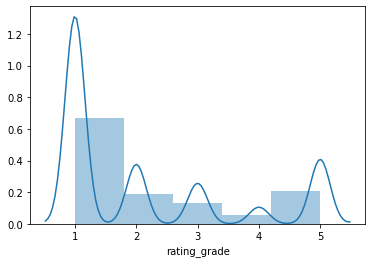

In [7]:
# Исключаем отзывы без рейтинга и распределяем рейтинги по отзывам. 
sns.distplot(df.rating_grade.dropna(), bins=5)
plt.show()

# 1. Посчитайте количество отзывов в разных городах и на разные банки

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 <a list of 20 Text xticklabel objects>)

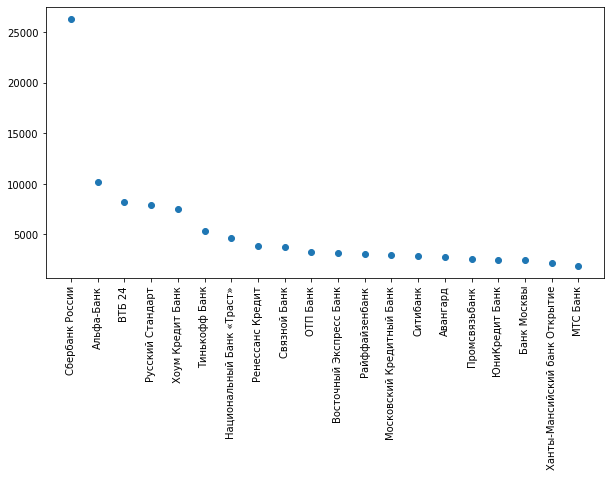

In [8]:
# Посмотрим на распределение банков по отзывам

plt.figure(figsize = (10,5))
plt.plot(df.groupby(by ="bank_name").count().sort_values(by="text", ascending = False)["text"][:20],'o')
plt.xticks(rotation = 90)

In [9]:
# Посмотрим на распределение городов по отзывам

city_plot = df.copy()
city_plot = city_plot.fillna("Other")

In [10]:
city_plot["city_low"] = city_plot.apply(lambda x: x.city.lower(), axis = 1)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 <a list of 20 Text xticklabel objects>)

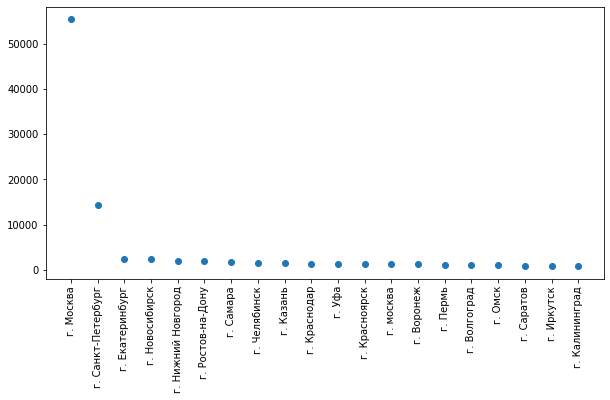

In [11]:
plt.figure(figsize = (10,5))
plt.plot(df.groupby(by ="city").count().sort_values(by="text", ascending = False)["text"][:20],'o')
plt.xticks(rotation = 90)

# 2. Постройте гистограмы длин слов в символах и в словах

In [12]:
regrex = re.compile('[А-Яа-яЁё]+')
df_low_text = df.text.str.lower()
df_low_text = df_low_text.apply(lambda x: regrex.findall(x))

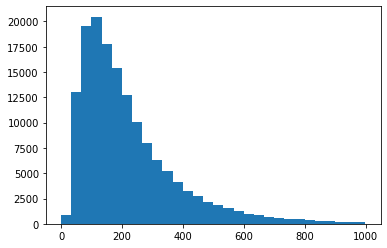

In [13]:
#Количество слов в отзыве

plt.hist(df_low_text.apply(len)[df_low_text.apply(len) < 1000], bins = 30)
plt.show()

In [14]:
all_words_list =[]
for words in df_low_text:
    for word in words:
        all_words_list.append(word)


(0, 30)

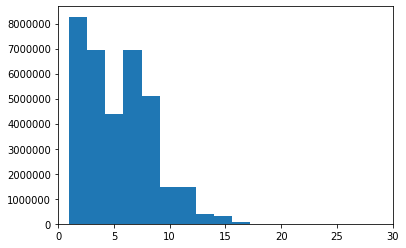

In [15]:
# Гистограмма длинн слов

plt.hist(list(map(len,all_words_list)), bins = 50)
plt.xlim(0,30)

# 3. Найдите 10 самых частых: слов, слов без стоп-слов, лемм

In [16]:
from collections import Counter
cntr = Counter()

cntr.update(all_words_list)

In [34]:
#Самые частые слова
cntr.most_common(10)

[('в', 1330307),
 ('и', 1058997),
 ('не', 852432),
 ('на', 707803),
 ('что', 640057),
 ('я', 577500),
 ('с', 463027),
 ('по', 372759),
 ('мне', 320958),
 ('банка', 275906)]

In [18]:
# Самые частые слова без стоп слов

In [19]:

from nltk.corpus import stopwords

In [20]:
mystopwords = set(stopwords.words("russian") + \
                  ['это', 'наш' , 'тыс', 'млн', 'млрд', 'также', 'г', 'т', 'д', 'банк', 'банку', 'банком', 'банка', 'банке'] )

In [21]:
all_words_no_stopwords = []

for token in tqdm_notebook(all_words_list):
    if token not in mystopwords:
        all_words_no_stopwords.append(token)

/Users/erik/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


In [35]:
cntr_stwrds = Counter()
cntr_stwrds.update(all_words_no_stopwords)
cntr_stwrds.most_common(10)

[('деньги', 131201),
 ('карту', 105829),
 ('карты', 101821),
 ('кредит', 81135),
 ('день', 76552),
 ('заявление', 70423),
 ('очень', 66824),
 ('отделение', 66647),
 ('время', 65762),
 ('счет', 56819)]

In [23]:
from pymorphy2 import MorphAnalyzer
pm2 = MorphAnalyzer()

In [24]:

def text_beautifier(text, rule = '[А-Яа-яЁё]+'):
    regex = re.compile(rule)
    text = text.lower()
    text = regex.findall(text)
    text = ' '.join(text)
    return text

def remove_stopwords(text, mystopwords = mystopwords):
    try:
        return " ".join([token for token in text.split() if not token in mystopwords])
    except:
        return ""

def lemmatize(text, pm2=pm2):
    try:
        lemmas = [pm2.parse(word)[0].normal_form for word in text.split()]
        return ' '.join(lemmas)
    except:
        return " "
    
mystoplemmas = ['который','прошлый','сей', 'свой', 'наш', 'мочь', 'банк', 'зао', 'ооо', 'оао', 'пао', 'рубль']
def remove_stoplemmas(text, mystoplemmas = mystoplemmas):
    try:
        return " ".join([token for token in text.split() if not token in mystoplemmas])
    except:
        return ""

In [25]:
df['lemma'] = df.apply(lambda x: text_beautifier(x.text, '[А-Яа-яЁё]+'), axis=1)

In [26]:
df['lemma'] = df.apply(lambda x: remove_stopwords(x.lemma, mystopwords), axis=1)

In [27]:
df['lemma'] = df['lemma'].apply(lemmatize)

In [28]:
df['lemma'] = df['lemma'].apply(remove_stoplemmas)

In [30]:
df_lemmas = df.lemma.tolist()

In [31]:

all_lemmas_list = []
for words in df_lemmas:
    words = words.split(' ')
    for word in words:
        all_lemmas_list.append(word)

In [36]:
cntr_lemmas = Counter()
cntr_lemmas.update(all_lemmas_list)
cntr_lemmas.most_common(10)

[('карта', 334999),
 ('деньга', 179819),
 ('день', 170149),
 ('мой', 162097),
 ('кредит', 156176),
 ('отделение', 144050),
 ('счёт', 142646),
 ('клиент', 136893),
 ('сотрудник', 134168),
 ('сказать', 114440)]

# 4. Найдите 10 самых частых существительных

In [37]:
all_nouns_list = []
for lemma in tqdm_notebook(all_lemmas_list):
    if 'NOUN' in pm2.parse(lemma)[0].tag:
        all_nouns_list.append(lemma)

/Users/erik/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [39]:
cntr_nouns = Counter()
cntr_nouns.update(all_nouns_list)
cntr_nouns.most_common(10)

[('карта', 334999),
 ('деньга', 179819),
 ('день', 170149),
 ('кредит', 156176),
 ('отделение', 144050),
 ('счёт', 142646),
 ('клиент', 136893),
 ('сотрудник', 134168),
 ('сумма', 111232),
 ('заявление', 104419)]

# 5.Постройте кривые Ципфа и Хипса

In [40]:
# Кривая Ципфа 

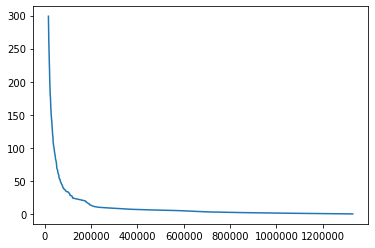

In [41]:
freqs = list(cntr.values())
freqs = sorted(freqs, reverse = True)

fig, ax = plt.subplots()
ax.plot(freqs[:300], range(300))
plt.show()

In [42]:
# Кривая Хипса

In [43]:
n_tokens = []
n_types = []
types = set()

for word, words in zip(all_words_list, range(len(all_words_list))):
    n_tokens.append(words)
    types.add(word)
    n_types.append(len(types))

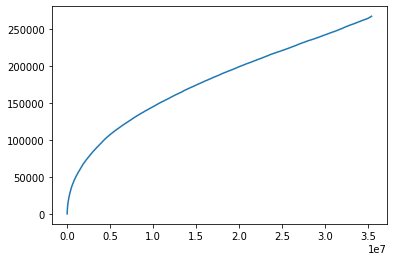

In [44]:
fig, ax = plt.subplots()
ax.plot(n_tokens, n_types)
plt.show()

# 6.Ответьте на следующие вопросы: какое слово встречается чаще, "сотрудник" или "клиент"? сколько раз встречается слова "мошенничество" и "доверие"?


In [45]:
print('Слово "сотрудник" встречается ' + str(cntr_lemmas['сотрудник']) + \
      ', а слово "клиент" ' + str(cntr_lemmas['клиент']) + '. \nВыходит, "клиент" встречается чаще, если мы говорим о леммах слов.')

Слово "сотрудник" встречается 134168, а слово "клиент" 136893. 
Выходит, "клиент" встречается чаще, если мы говорим о леммах слов.


In [46]:

print('Слово "мошенничество" встречается ' + str(cntr_lemmas['мошенничество']) + \
      ', а слово "доверие" ' + str(cntr_lemmas['доверие']))

Слово "мошенничество" встречается 3244, а слово "доверие" 2108


# 7. В поле "rating_grade" записана оценка отзыва по шкале от 1 до 5. Используйте меру  𝑡𝑓−𝑖𝑑𝑓 , для того, чтобы найти ключевые слова и биграмы для положительных отзывов (с оценкой 5) и отрицательных отзывов (с оценкой 1)

In [47]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(ngram_range=(1,2))

In [48]:
corpus_checked = df[~df['rating_not_checked']]
corpus_lemmas = corpus_checked.lemma.tolist()
positive_ids = corpus_checked[corpus_checked['rating_grade'] == 5].index.tolist()
negative_ids = corpus_checked[corpus_checked['rating_grade'] == 1].index.tolist()

In [49]:
tfidf_matrix = vectorizer.fit_transform(corpus_lemmas)

In [50]:
features = vectorizer.get_feature_names()

In [51]:

positive = []
negative = []
for row in tqdm_notebook(range(tfidf_matrix.shape[0])):
    if row in positive_ids:
        positive.append(tfidf_matrix[row])
    if row in negative_ids:
        negative.append(tfidf_matrix[row])

/Users/erik/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


In [52]:

pos_keywrds = np.zeros_like(positive[0].toarray()[0])
for each in tqdm_notebook(positive):
    pos_keywrds += each.toarray()[0]

/Users/erik/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [53]:

neg_keywrds = np.zeros_like(negative[0].toarray()[0])
for each in tqdm_notebook(negative):
    neg_keywrds += each.toarray()[0]

/Users/erik/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [54]:

feedbacks = pd.DataFrame(np.array((np.array(features), pos_keywrds, neg_keywrds)).T, columns=['key_words', 'tfidf_positive', 'tfidf_negative'])

In [55]:
feedbacks['n_gramm'] = feedbacks.apply(lambda x: len(x.key_words.split()), axis=1)

In [56]:
print('Ключевые слова для положительных отзывов:')
print(feedbacks.sort_values(by='tfidf_positive', ascending=False)[feedbacks['n_gramm'] == 1].key_words[:10].tolist(), '\n')
print('Биграмы для положительных отзывов:')
print(feedbacks.sort_values(by='tfidf_positive', ascending=False)[feedbacks['n_gramm'] == 2].key_words[:10].tolist(), '\n')
print('Ключевые слова для отрицательных отзывов:')
print(feedbacks.sort_values(by='tfidf_negative', ascending=False)[feedbacks['n_gramm'] == 1].key_words[:10].tolist(), '\n')
print('Биграмы для отрицательных отзывов:')
print(feedbacks.sort_values(by='tfidf_negative', ascending=False)[feedbacks['n_gramm'] == 2].key_words[:10].tolist(), '\n')

Ключевые слова для положительных отзывов:


/Users/erik/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


['такой', 'банкомат', 'сумма', 'довольный', 'благодарность', 'какой', 'открыть', 'оформить', 'положительный', 'услуга'] 

Биграмы для положительных отзывов:


/Users/erik/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


['последний время', 'карта готовый', 'уточнить пожалуйста', 'хороший впечатление', 'чётко быстро', 'кредитный договор', 'возникнуть проблема', 'снять деньга', 'срок действие', 'день получить'] 

Ключевые слова для отрицательных отзывов:


/Users/erik/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


['факт', 'невозможно', 'объяснять', 'пожалуйста', 'управлять', 'оплачивать', 'предлагать', 'письменный', 'спустя', 'посмотреть'] 

Биграмы для отрицательных отзывов:


/Users/erik/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


['номер телефон', 'дебетовый карта', 'срок рассмотрение', 'погашение кредит', 'кредитный договор', 'мой карта', 'обратиться отделение', 'конец провод', 'транспортный карта', 'сказать ответ'] 



## Часть 2. Тематическое моделирование [20/100]

1. Постройте несколько тематических моделей коллекции документов с разным числом тем. Приведите примеры понятных (интерпретируемых) тем.
2. Найдите темы, в которых упомянуты конкретные банки (Сбербанк, ВТБ, другой банк). Можете ли вы их прокомментировать / объяснить?

Эта часть задания может быть сделана с использованием gensim. 

In [57]:
from gensim.corpora import Dictionary
from gensim.models import  *

In [58]:
dataset = [corpus_lemmas[i].split() for i in range(len(corpus_lemmas))]
dct = Dictionary(dataset)

In [59]:
corpus = [dct.doc2bow(line) for line in dataset]
model = TfidfModel(corpus)
vector = model[corpus]

In [60]:
lsi = lsimodel.LsiModel(corpus=corpus, id2word=dct, num_topics=5)
lsi.show_topics()

[(0,
  '0.468*"карта" + 0.200*"мой" + 0.191*"деньга" + 0.185*"день" + 0.175*"счёт" + 0.164*"отделение" + 0.154*"кредит" + 0.153*"сотрудник" + 0.149*"клиент" + 0.133*"заявление"'),
 (1,
  '-0.792*"карта" + 0.358*"кредит" + 0.149*"договор" + 0.136*"сумма" + 0.115*"платёж" + 0.112*"сотрудник" + 0.091*"день" + 0.089*"документ" + 0.085*"клиент" + 0.082*"мой"'),
 (2,
  '-0.532*"кредит" + 0.432*"деньга" + 0.269*"счёт" + -0.269*"карта" + -0.237*"кредитный" + 0.230*"вклад" + 0.190*"банкомат" + 0.140*"отделение" + -0.131*"договор" + 0.099*"сбербанк"'),
 (3,
  '-0.449*"счёт" + -0.274*"сумма" + -0.262*"деньга" + 0.212*"отделение" + -0.212*"средство" + 0.175*"клиент" + 0.162*"сотрудник" + -0.156*"платёж" + -0.149*"заявление" + -0.137*"договор"'),
 (4,
  '0.347*"мой" + -0.312*"вклад" + -0.262*"кредит" + 0.243*"заявление" + 0.237*"дать" + 0.235*"номер" + 0.218*"сбербанк" + -0.218*"деньга" + 0.169*"сотрудник" + -0.146*"сумма"')]

In [61]:
#вероятно 0 тема про счета и карточки
#1 - кредит на карточке
#2- кредит на счету
#3 - средства на счету
#4- вклад сбербанка

#в 4-ой теме упоминается сбербанк - касательно вопросова вкладов и кредитов

## Часть 3. Классификация текстов [40/100]

Сформулируем для простоты задачу бинарной классификации: будем классифицировать на два класса, то есть, различать резко отрицательные отзывы (с оценкой 1) и положительные отзывы (с оценкой 5). 

1.  Составьте обучающее и тестовое множество: выберите из всего набора данных N1 отзывов с оценкой 1 и N2 отзывов с оценкой 5 (значение N1 и N2 – на ваше усмотрение). Используйте ```sklearn.model_selection.train_test_split``` для разделения множества отобранных документов на обучающее и тестовое. 
2. Используйте любой известный вам алгоритм классификации текстов для решения задачи и получите baseline. Сравните разные варианты векторизации текста: использование только униграм, пар или троек слов или с использованием символьных $n$-грам. 
3. Сравните, как изменяется качество решения задачи при использовании скрытых тем в качестве признаков:
* 1-ый вариант: $tf-idf$ преобразование (```sklearn.feature_extraction.text.TfidfTransformer```) и сингулярное разложение (оно же – латентый семантический анализ) (```sklearn.decomposition.TruncatedSVD```), 
* 2-ой вариант: тематические модели LDA (```sklearn.decomposition.LatentDirichletAllocation```). 

Используйте accuracy и F-measure для оценки качества классификации. 

Ниже написан примерный Pipeline для классификации текстов. 

Эта часть задания может быть сделана с использованием sklearn. 

In [62]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.decomposition import TruncatedSVD, LatentDirichletAllocation
from sklearn.metrics import accuracy_score, f1_score

In [63]:
neg_samples = negative_ids[:len(positive_ids)]
pos_sapmles = positive_ids
print('negative: ', len(neg_samples), '\npositive: ', len(pos_sapmles))

negative:  14713 
positive:  14713


In [65]:

neg_corpus = []
pos_corpus = []

for i in range(len(corpus_lemmas)):
    if i in neg_samples:
        neg_corpus.append([corpus_lemmas[i], 0])
    if i in pos_sapmles:
        pos_corpus.append([corpus_lemmas[i], 1])

In [66]:
data = np.array(neg_corpus + pos_corpus).T

In [67]:
X_train, X_test, y_train, y_test = train_test_split(data[0], data[1], test_size=0.30, random_state=42)

In [68]:
clf = Pipeline([ 
    ('vect', CountVectorizer()), 
    ('tfidf', TfidfTransformer()), 
    ('tm', TruncatedSVD(n_components=30, random_state=42)), 
    ('clf', RandomForestClassifier(random_state=42))
])

# Baseline(униграмы)

In [69]:

clf.fit(X_train, y_train)

/Users/erik/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=Non...
                 RandomForestClassifier(bootstrap=True, class_weight=None,
                                        criterion='gini', max_depth=None,
                                        max_features='auto',
                                        max_leaf_nodes=None,
                                        min_impurity_decrease=0.0

In [71]:

print('Test score\n\tacc:\t', round(accuracy_score(y_test, clf.predict(X_test)), 3), \
      '\n\tf1:\t', round(f1_score(y_test, clf.predict(X_test), pos_label='1'), 3))

Test score
	acc:	 0.888 
	f1:	 0.882


# Биграмы

In [72]:
clf_bi = Pipeline([ 
    ('vect', CountVectorizer(ngram_range=(2,2))), 
    ('tfidf', TfidfTransformer()), 
    ('tm', TruncatedSVD(n_components=30, random_state=42)), 
    ('clf', RandomForestClassifier(random_state=42))
])

In [73]:
clf_bi.fit(X_train, y_train)

/Users/erik/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(2, 2), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=Non...
                 RandomForestClassifier(bootstrap=True, class_weight=None,
                                        criterion='gini', max_depth=None,
                                        max_features='auto',
                                        max_leaf_nodes=None,
                                        min_impurity_decrease=0.0

In [74]:
print('Test score\n\tacc:\t', round(accuracy_score(y_test, clf_bi.predict(X_test)), 3), \
      '\n\tf1:\t', round(f1_score(y_test, clf_bi.predict(X_test), pos_label='1'), 3))

Test score
	acc:	 0.866 
	f1:	 0.859


# Триграмы

In [75]:
clf_tri = Pipeline([ 
    ('vect', CountVectorizer(ngram_range=(3,3))), 
    ('tfidf', TfidfTransformer()), 
    ('tm', TruncatedSVD(n_components=30, random_state=42)), 
    ('clf', RandomForestClassifier(random_state=42))
])

In [76]:
clf_tri.fit(X_train, y_train)

/Users/erik/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(3, 3), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=Non...
                 RandomForestClassifier(bootstrap=True, class_weight=None,
                                        criterion='gini', max_depth=None,
                                        max_features='auto',
                                        max_leaf_nodes=None,
                                        min_impurity_decrease=0.0

In [77]:
print('Test score\n\tacc:\t', round(accuracy_score(y_test, clf_tri.predict(X_test)), 3), \
      '\n\tf1:\t', round(f1_score(y_test, clf_tri.predict(X_test), pos_label='1'), 3))

Test score
	acc:	 0.741 
	f1:	 0.709


# Символьные n-грамы

In [78]:
clf_n = Pipeline([ 
    ('vect', CountVectorizer(analyzer='char', ngram_range=(2,10))), 
    ('tfidf', TfidfTransformer()), 
    ('tm', TruncatedSVD(n_components=30, random_state=42)), 
    ('clf', RandomForestClassifier(random_state=42))
])

In [79]:
clf_n.fit(X_train, y_train)

/Users/erik/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='char', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(2, 10), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=No...
                 RandomForestClassifier(bootstrap=True, class_weight=None,
                                        criterion='gini', max_depth=None,
                                        max_features='auto',
                                        max_leaf_nodes=None,
                                        min_impurity_decrease=0.0

In [80]:
print('Test score\n\tacc:\t', round(accuracy_score(y_test, clf_n.predict(X_test)), 3), \
      '\n\tf1:\t', round(f1_score(y_test, clf_n.predict(X_test), pos_label='1'), 3))

Test score
	acc:	 0.883 
	f1:	 0.877


In [81]:
# Видим что использование униграмм дало лучший результат! На втором месте n-grams

In [82]:
clf_n_LDA = Pipeline([ 
    ('vect', CountVectorizer()), 
    ('tfidf', TfidfTransformer()), 
    ('lda', LatentDirichletAllocation(random_state=42)), 
    ('clf', RandomForestClassifier(random_state=42))
])

In [83]:
clf_n_LDA.fit(X_train, y_train)

/Users/erik/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=Non...
                 RandomForestClassifier(bootstrap=True, class_weight=None,
                                        criterion='gini', max_depth=None,
                                        max_features='auto',
                                        max_leaf_nodes=None,
                                        min_impurity_decrease=0.0

In [84]:

print('Test score\n\tacc:\t', round(accuracy_score(y_test, clf_n_LDA.predict(X_test)), 3), \
      '\n\tf1:\t', round(f1_score(y_test, clf_n_LDA.predict(X_test), pos_label='1'), 3))


Test score
	acc:	 0.53 
	f1:	 0.486


In [85]:
# LDA работает очень плохо